# Example 2: Fault properties from extracted network
This example describes how to calculat the strike and length of faults in a network

## Setup

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/fault_analysis_toolbox/blob/master/examples/2-fault_properties/2_fault_properties.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
6. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.

## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install them:

In [1]:
!pip3 install git+https://github.com/thilowrona/fatbox.git

  Cloning https://github.com/thilowrona/fatbox.git to /tmp/pip-req-build-c2_xvzy9
  Running command git clone -q https://github.com/thilowrona/fatbox.git /tmp/pip-req-build-c2_xvzy9
     |████████████████████████████████| 163kB 3.9MB/s 
     |████████████████████████████████| 103.4MB 85kB/s 
  Cloning https://github.com/ulikoehler/cv_algorithms.git to /tmp/pip-install-r2cd5jjf/cv-algorithms
  Running command git clone -q https://github.com/ulikoehler/cv_algorithms.git /tmp/pip-install-r2cd5jjf/cv-algorithms
  Created wheel for fatbox: filename=fatbox-0.0.1-cp37-none-any.whl size=25833 sha256=8013a1b4f152de035f7c6f8b354b8190cfd7e73227b78381962f83f5fe74fb07
  Stored in directory: /tmp/pip-ephem-wheel-cache-hjnm6pr2/wheels/3c/75/06/4f57a6a85e140ffdf1280b29ebde7d5e62277dfc68e4aeb466
  Created wheel for network: filename=network-0.1-cp37-none-any.whl size=3157 sha256=3238c0f21b0961a9480745e23c370e1c70b75d8eb5f4f512a622c5d23a90aac1
  Stored in directory: /root/.cache/pip/wheels/f6/e7/6a/7098

In [2]:
!git clone https://github.com/thilowrona/fatbox_tutorials

Cloning into 'fatbox_tutorials'...
remote: Enumerating objects: 282, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 282 (delta 32), reused 0 (delta 0), pack-reused 171
Receiving objects: 100% (282/282), 29.97 MiB | 27.01 MiB/s, done.
Resolving deltas: 100% (103/103), done.


Now we can load the python packages:

In [11]:
import math
import numpy as np 
import networkx as nx
import pickle
import matplotlib.pyplot as plt

from fatbox.metrics import compute_edge_values
from fatbox.plots import plot_components, plot_edge_attribute, plot_rose

## Load fault network

First, we load a fault network extracted from an oblique rift model:

In [5]:
G = pickle.load(open('/content/fatbox_tutorials/2-fault_properties/g_27.p', 'rb'))          

Now we can visualize the faults and look at the orientations:

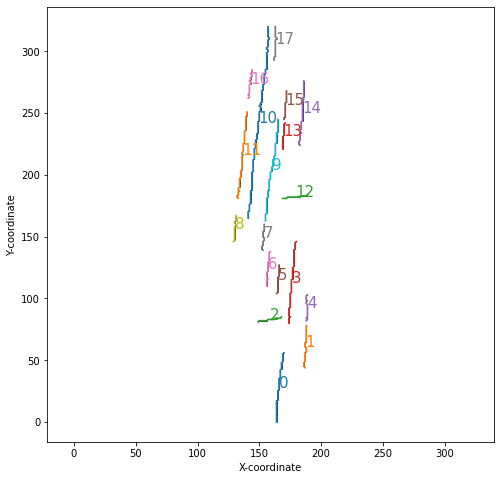

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
plot_components(G, ax, label=True)
ax.axis('equal')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
plt.show()

We can see that most faults are striking N-S and a few E-W. Let's calculate the strike of the edges of the network:

In [7]:
for edge in G.edges:
  x1 = G.nodes[edge[0]]['pos'][0]
  x2 = G.nodes[edge[1]]['pos'][0]
  y1 = G.nodes[edge[0]]['pos'][1]
  y2 = G.nodes[edge[1]]['pos'][1]

  if (x2-x1)<0:
    strike = math.degrees(math.atan2((x2-x1),(y2-y1))) + 360
  else:
    strike = math.degrees(math.atan2((x2-x1),(y2-y1)))
  
  #Scale to [0, 180]
  if strike<=180:
    G.edges[edge]['strike'] = strike
  else:
    G.edges[edge]['strike'] = strike - 180

Let's plot these strikes as edge attributes using this function:

In [12]:
def plot_edge_attribute(G, attribute, ax=[]):
    
    if ax==[]:
        fig, ax = plt.subplots() 

    nx.draw(G,
            pos = nx.get_node_attributes(G, 'pos'),
            node_size = 0.001,
            ax=ax)

    nx.draw_networkx_edges(G,
                           pos = nx.get_node_attributes(G, 'pos'),
                           edge_color = np.array([G.edges[edge][attribute] for edge in G.edges]),
                           edge_cmap=plt.cm.twilight_shifted,
                           ax=ax)
    ax.axis('equal')

    # Colorbar
    cmap = plt.cm.twilight_shifted
    vmax = compute_edge_values(G, attribute, 'max')
    vmin = compute_edge_values(G, attribute, 'min')
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
            
    cbar = plt.colorbar(sm, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(attribute, rotation=270)

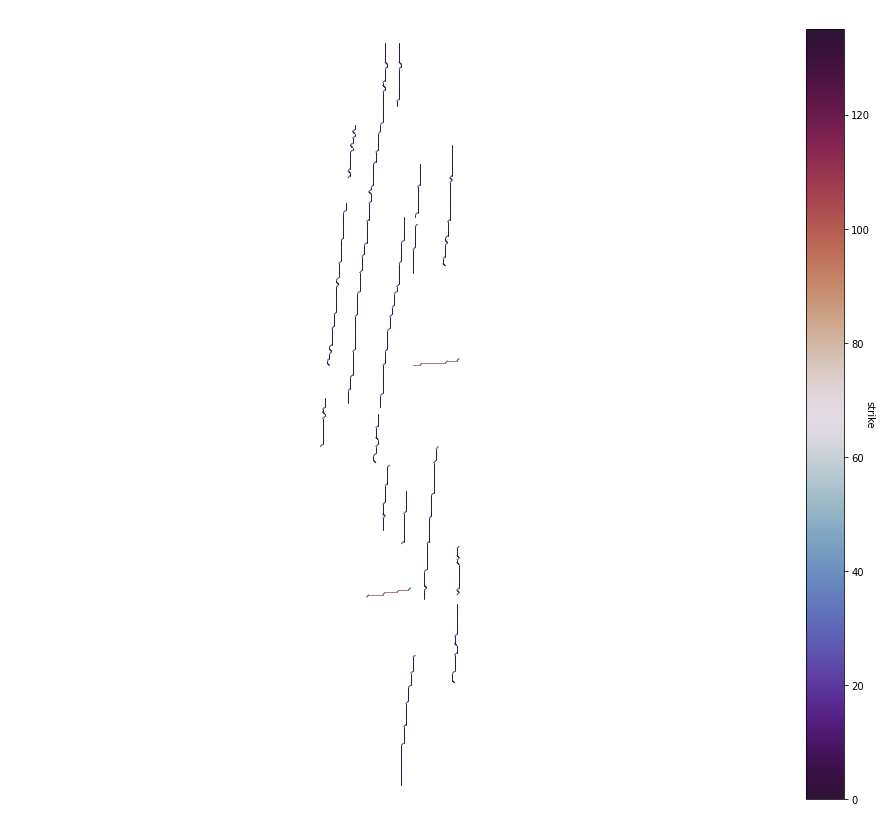

In [13]:
fig, ax = plt.subplots(figsize=(15,15))
plot_edge_attribute(G, 'strike', ax)

Looks a bit odd, let's zoom in:

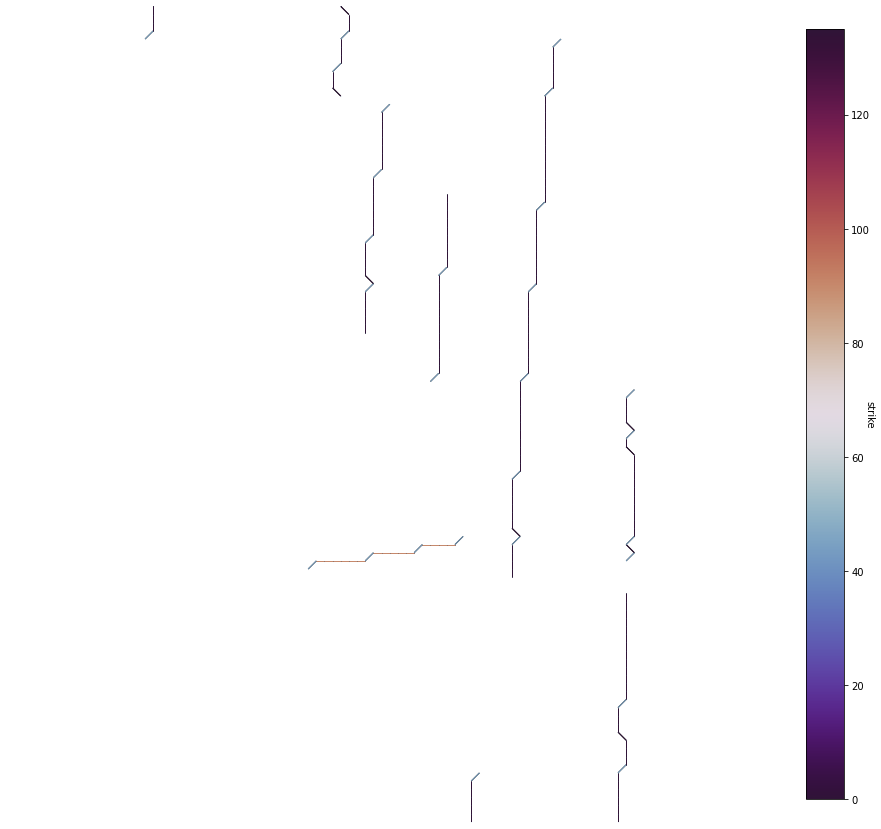

In [14]:
fig, ax = plt.subplots(figsize=(15,15))
plot_edge_attribute(G, 'strike', ax)
ax.set_ylim([50, 150])
plt.show()

Okay, the edges have very discrete strikes (0, 45, 90 degrees), because they were extracted from a regular array. This becomes even more evident when we plot the Rose diagram (a polar histogram of the strikes):

In [15]:
def plot_rose(strikes, lengths=[], ax=[]):    
    
    if lengths ==[]:
        lengths = np.ones_like(np.array(strikes))

    bin_edges = np.arange(-5, 366, 10)
    number_of_strikes, bin_edges = np.histogram(strikes, bin_edges, weights = lengths)           
    number_of_strikes[0] += number_of_strikes[-1]
    half = np.sum(np.split(number_of_strikes[:-1], 2), 0)
    two_halves = np.concatenate([half, half])
    
    cmap = plt.cm.twilight_shifted(np.concatenate((np.linspace(0, 1, 18), np.linspace(0, 1, 18)), axis=0))
     
    if ax==[]:
        fig = plt.figure(figsize=(8,8))
            
        ax = fig.add_subplot(111, projection='polar')
    
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.arange(0, 360, 10), labels=np.arange(0, 360, 10))
    
    ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves, 
           width=np.deg2rad(10), bottom=0.0, color=cmap, edgecolor='k')
    
    #    ax.set_rgrids(np.arange(1, two_halves.max() + 1, 2), angle=0, weight= 'black')
    ax.set_title('Rose Diagram', y=1.10, fontsize=15)
    
    # fig.tight_layout()


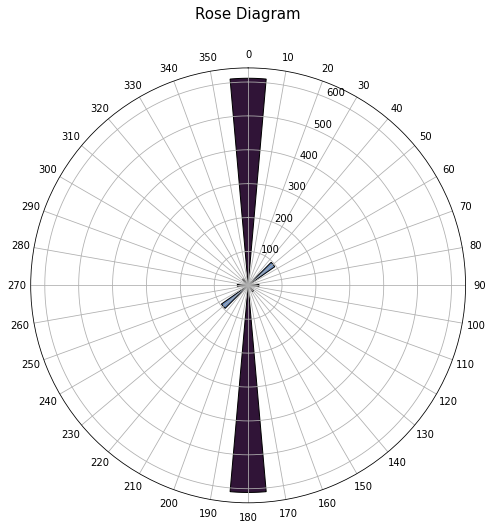

In [16]:
strikes = [G.edges[edge]['strike'] for edge in G.edges]
plot_rose(strikes)

Okay, that's not really what we want. We want the strikes of the faults, not the edges. So let's calculate those:

In [17]:
strikes = []
for cc in nx.connected_components(G):
  edges = G.edges(cc)
  edge_strikes = []
  for edge in edges:
    edge_strikes.append(G.edges[edge]['strike'])
  strikes.append(np.mean(edge_strikes))

and the fault lenghts as weights:

In [18]:
for edge in G.edges:
  G.edges[edge]['length'] = np.linalg.norm(np.array(G.nodes[edge[0]]['pos'])-np.array(G.nodes[edge[1]]['pos']))

In [19]:
lengths = []
for cc in nx.connected_components(G):
  edges = G.edges(cc)
  edge_lengths = []
  for edge in edges:
    edge_lengths.append(G.edges[edge]['length'])
  lengths.append(np.mean(edge_lengths))

Now we can plot the Rose diagram again:

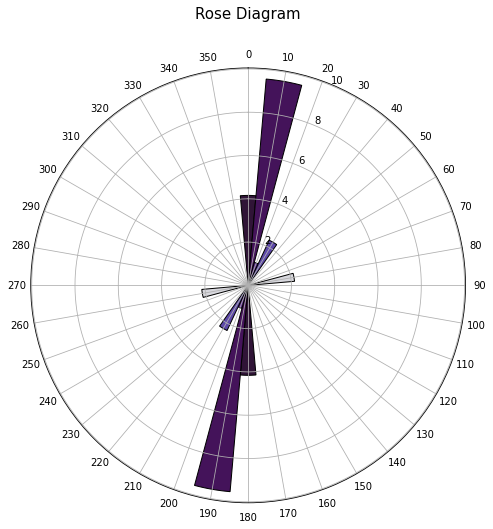

In [20]:
plot_rose(strikes, lengths)

That's a much better representation of the fault strikes in our network!

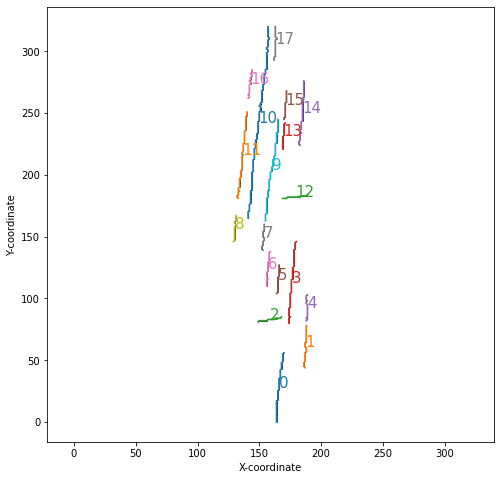

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
plot_components(G, ax, label=True)
ax.axis('equal')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
plt.show()